In [1]:
import librosa as librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
import librosa
from sklearn.svm import SVC 
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
import os
from librosa import power_to_db , util
import scipy

In [2]:
def mfccc( y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm="ortho", lifter=0):
    if S is None:
        # multichannel behavior may be different due to relative noise floor differences between channels
        S = power_to_db(librosa.feature.melspectrogram(y=y, sr=sr))

    M = scipy.fftpack.dct(S, axis=-2, type=dct_type, norm=norm)[..., :n_mfcc, :]

    if lifter > 0:
        # shape lifter for broadcasting
        LI = np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)
        LI = util.expand_to(LI, ndim=S.ndim, axes=-2)

        M *= 1 + (lifter / 2) * LI
        return M
    elif lifter == 0:
        return M
    else:
        raise ParameterError(
            "MFCC lifter={} must be a non-negative number".format(lifter)
        )

In [3]:
def rms(y=None, S=None, frame_length=2048, hop_length=512, center=True, pad_mode="constant",):
    if y is not None:
        if center:
            padding = [(0, 0) for _ in range(y.ndim)]
            padding[-1] = (int(frame_length // 2), int(frame_length // 2))
            y = np.pad(y, padding, mode=pad_mode)

        x = util.frame(y, frame_length=frame_length, hop_length=hop_length)

        # Calculate power
        power = np.mean(np.abs(x) ** 2, axis=-2, keepdims=True)
    elif S is not None:
        # Check the frame length
        if S.shape[-2] != frame_length // 2 + 1:
            raise ParameterError(
                "Since S.shape[-2] is {}, "
                "frame_length is expected to be {} or {}; "
                "found {}".format(
                    S.shape[-2], S.shape[-2] * 2 - 2, S.shape[-2] * 2 - 1, frame_length
                )
            )

        # power spectrogram
        x = np.abs(S) ** 2

        # Adjust the DC and sr/2 component
        x[..., 0, :] *= 0.5
        if frame_length % 2 == 0:
            x[..., -1, :] *= 0.5

        # Calculate power
        power = 2 * np.sum(x, axis=-2, keepdims=True) / frame_length ** 2
    else:
        raise ParameterError("Either `y` or `S` must be input.")

    return np.sqrt(power)

In [4]:
def spectral_centroid(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, freq=None, win_length=None, window="hann",
                      center=True, pad_mode="constant" ):
    S, n_fft = librosa.core.spectrum._spectrogram(
        y=y,
        S=S,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=center,
        pad_mode=pad_mode)
    
    if not np.isrealobj(S):
        raise ParameterError(
            "Spectral centroid is only defined " "with real-valued input"
        )
        
    elif np.any(S < 0):
        raise ParameterError(
            "Spectral centroid is only defined " "with non-negative energies"
        )
        
    # Compute the center frequencies of each bin
    if freq is None:
        freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
        
    if freq.ndim == 1:
        # reshape for broadcasting
        freq = util.expand_to(freq, ndim=S.ndim, axes=-2)
        
        # Column-normalize S
        
    return np.sum(freq * util.normalize(S, norm=1, axis=-2), axis=-2, keepdims=True)


In [5]:
def spectral_bandwidth(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window="hann", center=True,
    pad_mode="constant", freq=None, centroid=None, norm=True, p=2 ):
    S, n_fft = librosa.core.spectrum._spectrogram(
        y=y,
        S=S,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=center,
        pad_mode=pad_mode,
    )
    
    if not np.isrealobj(S):
        raise ParameterError(
            "Spectral bandwidth is only defined " "with real-valued input"
        )
    elif np.any(S < 0):
        raise ParameterError(
            "Spectral bandwidth is only defined " "with non-negative energies"
        )

    # centroid or center?
    if centroid is None:
        centroid = spectral_centroid(
            y=y, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq=freq
        )

    # Compute the center frequencies of each bin
    if freq is None:
        freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    if freq.ndim == 1:
        deviation = np.abs(
            np.subtract.outer(centroid[..., 0, :], freq).swapaxes(-2, -1)
        )
    else:
        deviation = np.abs(freq - centroid)

    # Column-normalize S
    if norm:
        S = util.normalize(S, norm=1, axis=-2)

    return np.sum(S * deviation ** p, axis=-2, keepdims=True) ** (1.0 / p)


In [6]:
def spectral_rolloff(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window="hann", center=True,
    pad_mode="constant", freq=None, roll_percent=0.85 ):
    if not 0.0 < roll_percent < 1.0:
        raise ParameterError("roll_percent must lie in the range (0, 1)")

    S, n_fft = librosa.core.spectrum._spectrogram(
        y=y,
        S=S,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=center,
        pad_mode=pad_mode,
    )

    if not np.isrealobj(S):
        raise ParameterError(
            "Spectral rolloff is only defined " "with real-valued input"
        )
    elif np.any(S < 0):
        raise ParameterError(
            "Spectral rolloff is only defined " "with non-negative energies"
        )

    # Compute the center frequencies of each bin
    if freq is None:
        freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Make sure that frequency can be broadcast
    if freq.ndim == 1:
        # reshape for broadcasting
        freq = util.expand_to(freq, ndim=S.ndim, axes=-2)

    total_energy = np.cumsum(S, axis=-2)
    # (channels,freq,frames)

    threshold = roll_percent * total_energy[..., -1, :]

    # reshape threshold for broadcasting
    threshold = np.expand_dims(threshold, axis=-2)

    ind = np.where(total_energy < threshold, np.nan, 1)

    return np.nanmin(ind * freq, axis=-2, keepdims=True)

In [7]:
def zero_crossing_rate(y, *, frame_length=2048, hop_length=512, center=True, **kwargs):
    # check if audio is valid
    util.valid_audio(y, mono=False)

    if center:
        padding = [(0, 0) for _ in range(y.ndim)]
        padding[-1] = (int(frame_length // 2), int(frame_length // 2))
        y = np.pad(y, padding, mode="edge")

    y_framed = util.frame(y, frame_length=frame_length, hop_length=hop_length)

    kwargs["axis"] = -2
    kwargs.setdefault("pad", False)

    crossings = librosa.zero_crossings(y_framed, **kwargs)

    return np.mean(crossings, axis=-2, keepdims=True)


In [8]:

header = 'filename rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

for i in range(1, 40):
    header += f' mfcc{i}'
header = header.split()
# print('CSV Header: ', header)
file = open("data.csv", 'w', newline='')
writer = csv.writer(file)
writer.writerow(header)
file.close()


def writeCsv(data):
    file = open("data.csv", 'a', newline='')
    writer = csv.writer(file)
    writer.writerow(data.split(","))
    file.close()



def feature_extraction(file_path):
    # iterate through all file
        y, sr = librosa.load(file_path, mono=True, duration=30)
            # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        # chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = rms(y=y)
        #rmse = librosa.feature.rms(y=y)
        spec_cent = spectral_centroid(y=y, sr=sr)
        #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = spectral_bandwidth(y=y, sr=sr)
        #spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = spectral_rolloff(y=y, sr=sr)
        #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = zero_crossing_rate(y)
        #zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = mfccc(y=y, sr=sr,n_mfcc=39)
        #mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=39)
        to_append = f'{file},{np.mean(rmse)},{np.mean(spec_cent)},{np.mean(spec_bw)},{np.mean(rolloff)},{np.mean(zcr)}'
        for e in mfcc:
            to_append += f',{np.mean(e)}'
        
        writeCsv(to_append)
        return to_append

to_append =[]





path ='./Data/Person_data/'

for file in os.listdir(path):
    # print(file)
    file_path = f"{path}\{file}"  
    data = feature_extraction(file_path)








    

In [9]:
def feature_extraction_array(file_path):
    to_append =[]
    # iterate through all file
    y, sr = librosa.load(file_path, mono=True, duration=30)
        # remove leading and trailing silence
    y, index = librosa.effects.trim(y)
    # chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    #rmse = librosa.feature.rms(y=y)
    rmse = rms(y=y)
    #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_cent = spectral_centroid(y=y, sr=sr)
    #spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bw = spectral_bandwidth(y=y, sr=sr)
    #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff = spectral_rolloff(y=y, sr=sr)
    #zcr = librosa.feature.zero_crossing_rate(y)
    zcr = zero_crossing_rate(y)
    #mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=39, n_fft=1024, hop_length=512)
    mfcc = mfccc(y=y, sr=sr,n_mfcc=39)
    to_append.append(np.mean(rmse))
    to_append.append(np.mean(spec_cent))
    to_append.append(np.mean(spec_bw))
    to_append.append(np.mean(rolloff))
    to_append.append(np.mean(zcr))
    for e in mfcc:
        to_append.append(np.mean(e))
    return to_append
    
    
def preProcessing(csvName):
    data = pd.read_csv(csvName)
    audioName = data['filename']
    speakerNumber = []
    for i in range(len(audioName)):
        speakerLetter = audioName[i][0]
        if speakerLetter == "A":
            speakerLetter = 0
        elif speakerLetter =="H":
            speakerLetter=1
        elif speakerLetter == "M":
            speakerLetter = 2
        elif speakerLetter =="Y":
            speakerLetter = 3
        else:
            speakerLetter = 4
        speakerNumber.append(speakerLetter)

    data = data.drop(['filename'],axis=1)


    print(data.tail())
    
    return data, speakerNumber


***Speaker Recognition***

In [10]:
data, number = preProcessing("data.csv")


         rmse  spectral_centroid  spectral_bandwidth      rolloff  \
107  0.036961         900.262590         1228.633450  1710.715110   
108  0.030798        1110.509419         1415.479838  2223.205344   
109  0.043172        1029.468179         1322.851465  1998.239840   
110  0.039588        1086.552395         1351.697446  2114.756303   
111  0.029859         916.739124         1247.753847  1742.170715   

     zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
107            0.035929 -384.608643  144.547806   8.870942  20.455149   
108            0.047576 -377.867615  147.641052  12.861173  29.303251   
109            0.039006 -368.788727  147.944244   3.276975  19.193602   
110            0.046777 -375.518097  142.554230   7.776324  18.943033   
111            0.038239 -399.210754  149.685547  15.412180  12.311265   

         mfcc5  ...    mfcc30    mfcc31    mfcc32    mfcc33    mfcc34  \
107  17.201056  ... -5.936404 -3.372059 -6.162612 -3.362956 -1.793169   


In [11]:
X= np.array(data)

y=np.asarray(number)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=123
    )


In [28]:
svm_model= svm.SVC(kernel='linear' , C=0.01)
svm_model.fit(X_train, y_train) 

y_pred = svm_model.predict(X_test)



In [14]:
testing = feature_extraction_array('./Recording (13).wav')
y_predict = svm_model.predict([testing])



print(y_predict)


[2]


In [29]:
from sklearn import metrics
y_pred_t = svm_model.predict(X_train)
accuracy_t = metrics.accuracy_score(y_train,y_pred_t)


print(f"  Train model accuracy = {100* accuracy_t:.3} %")
accuracy = metrics.accuracy_score(y_test,y_pred)



print(f"  Test model accuracy = {100* accuracy:.3} %")


  Train model accuracy = 1e+02 %
  Test model accuracy = 91.1 %


***Plot  SVM***

In [16]:
import matplotlib.pyplot as plt

ValueError: Argument Z must be 2-dimensional.

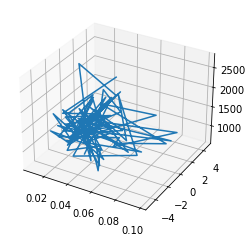

In [17]:
vector = np.vectorize(np.int_)
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot3D(X_train[:,0],X_train[:,43],X_train[:,1])
ax.plot3D(testing[0],testing[43],testing[1],c='b')
ax.plot_surface(X_train[:,0],X_train[:,43],X_train[:,1],c=vector(y_pred_t))

***Spoken Digit Recognition***

In [ ]:
""""loop that clac all differnces between each item in array with the other"""
def distance(array):    
    dist = []
    for i in range(len(array)):
        for j in range(len(array)):
            dist.append(np.linalg.norm(array[i]-array[j]))
    return dist 

In [ ]:
dist = distance(vector(y_train))

In [ ]:
import pickle as plk

In [ ]:
filename = 'Person_model.sav'
plk.dump(svm_model, open(filename, 'wb'))